# DocReach - Predicting Physician Speciality for a Marketing Company
# Exploratory Data Analysis

In [27]:
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import numpy as np
import pandas as pd
#import sklearn
import pickle
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, learning_curve 
from sklearn.tree import DecisionTreeClassifier 



%matplotlib inline

In [2]:
ph = pd.read_csv("physicians.csv")

In [3]:
pr = pd.read_csv("procedures.csv")

In [4]:
ph.head()

,id,specialty
0,0,General Surgery
1,1,Unknown
2,2,Family Practice
3,3,Emergency Medicine
4,4,Plastic and Reconstructive Surgery


In [5]:
pr.head()

,physician_id,procedure_code,procedure,number_of_patients
0,0,99202,"new_patient_office_or_other_outpatient_visit,_...",14
1,0,99203,"new_patient_office_or_other_outpatient_visit,_...",15
2,0,99205,"new_patient_office_or_other_outpatient_visit,_...",12
3,0,99212,established_patient_office_or_other_outpatient...,27
4,0,99213,established_patient_office_or_other_outpatient...,16


In [6]:
df = pd.merge(pr, ph, left_on='physician_id', right_on='id', how='left')

In [7]:
df.head()

,physician_id,procedure_code,procedure,number_of_patients,id,specialty
0,0,99202,"new_patient_office_or_other_outpatient_visit,_...",14,0,General Surgery
1,0,99203,"new_patient_office_or_other_outpatient_visit,_...",15,0,General Surgery
2,0,99205,"new_patient_office_or_other_outpatient_visit,_...",12,0,General Surgery
3,0,99212,established_patient_office_or_other_outpatient...,27,0,General Surgery
4,0,99213,established_patient_office_or_other_outpatient...,16,0,General Surgery


In [10]:
#df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 587774 entries, 0 to 587773
Data columns (total 6 columns):
physician_id          587774 non-null int64
procedure_code        587774 non-null object
procedure             587774 non-null object
number_of_patients    587774 non-null int64
id                    587774 non-null int64
specialty             587774 non-null object
dtypes: int64(3), object(3)
memory usage: 31.4+ MB


In [11]:
#df.specialty.value_counts()

Cardiology                                     190095
Unknown                                        181063
Diagnostic Radiology                            39217
Internal Medicine                               36357
Family Practice                                 26729
Orthopedic Surgery                              10276
Ophthalmology                                    8015
Anesthesiology                                   7043
Hematology/Oncology                              6731
Dermatology                                      6075
Emergency Medicine                               6063
Urology                                          5710
Gastroenterology                                 5359
Pulmonary Disease                                4887
General Surgery                                  4658
Pathology                                        4276
Neurology                                        4087
Obstetrics/Gynecology                            3636
Otolaryngology              

In [12]:
#pd.get_dummies(df.specialty)

In [14]:
df[~df.specialty.str.contains("Un")].to_csv("labelled.csv")
df[df.specialty.str.contains("Un")].to_csv("Un-labelled.csv")

In [11]:
# labelled data
data = pd.read_csv("labelled.csv")

In [12]:
data.specialty[data.specialty.str.contains("Card")].value_counts()

Cardiology                   190095
Cardiac Electrophysiology      1665
Cardiac Surgery                 500
Name: specialty, dtype: int64

In [13]:
data['is_cardiologist'] = data.specialty.str.contains("Card")

In [14]:
data.head()

,Unnamed: 0,physician_id,procedure_code,procedure,number_of_patients,id,specialty,is_cardiologist
0,0,0,99202,"new_patient_office_or_other_outpatient_visit,_...",14,0,General Surgery,False
1,1,0,99203,"new_patient_office_or_other_outpatient_visit,_...",15,0,General Surgery,False
2,2,0,99205,"new_patient_office_or_other_outpatient_visit,_...",12,0,General Surgery,False
3,3,0,99212,established_patient_office_or_other_outpatient...,27,0,General Surgery,False
4,4,0,99213,established_patient_office_or_other_outpatient...,16,0,General Surgery,False


In [15]:
#data.groupby('specialty').describe()

In [16]:
data.groupby('is_cardiologist').describe()

Unnamed: 0                                                 \
                     count           mean            std   min        25%   
is_cardiologist                                                             
False             214430.0  293445.938232  169667.925189   0.0  146176.25   
True              192260.0  293741.866426  170205.119552  18.0  146439.75   

                                                      id                \
                      50%        75%       max     count          mean   
is_cardiologist                                                          
False            294889.5  441971.75  587746.0  214430.0  18023.521867   
True             290595.5  440515.25  587701.0  192260.0  18041.212145   

                  ...    number_of_patients         physician_id  \
                  ...                   75%     max        count   
is_cardiologist   ...                                              
False             ...                  75.0  8372.0     214430.0   
True              ...                 106.0  6757.0     192260.0   

                                                                            \
                         mean           std  min     25%      50%      75%   
is_cardiologist                                                              
False            18023.521867  10403.446172  0.0  8943.0  18193.0  27125.0   
True             18041.212145  10436.225764  5.0  8963.0  17890.0  27034.0   

                          
                     max  
is_cardiologist           
False            36023.0  
True             36020.0  

[2 rows x 32 columns]

In [17]:
data['length'] = data['procedure'].map(lambda text: len(text))

In [18]:
data.head()

,Unnamed: 0,physician_id,procedure_code,procedure,number_of_patients,id,specialty,is_cardiologist,length
0,0,0,99202,"new_patient_office_or_other_outpatient_visit,_...",14,0,General Surgery,False,66
1,1,0,99203,"new_patient_office_or_other_outpatient_visit,_...",15,0,General Surgery,False,66
2,2,0,99205,"new_patient_office_or_other_outpatient_visit,_...",12,0,General Surgery,False,66
3,3,0,99212,established_patient_office_or_other_outpatient...,27,0,General Surgery,False,74
4,4,0,99213,established_patient_office_or_other_outpatient...,16,0,General Surgery,False,74


In [19]:
data.length.plot(bins=20, kind='hist');

<IPython.core.display.Javascript object>

In [20]:
data.length.describe()

count    406690.000000
mean         70.073933
std          31.574847
min           6.000000
25%          53.000000
50%          66.000000
75%          83.000000
max         256.000000
Name: length, dtype: float64

In [15]:
#print(list(data.procedure[data.length > 255]))

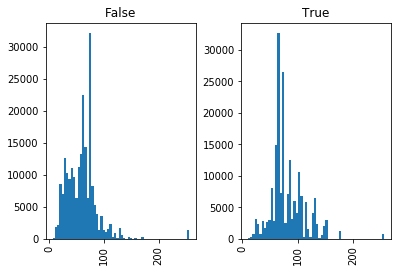

In [28]:
# Is there any difference in message length between cardiologist and non-cardiologists ?
data.hist(column='length', by='is_cardiologist', bins=60);
# todo : create combined histogram

c:\users\ss\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


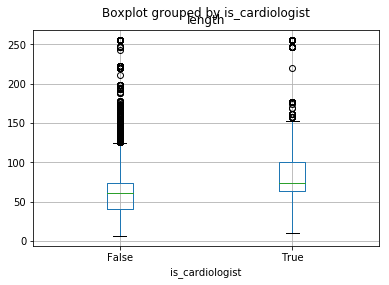

In [30]:
data.boxplot(column='length', by='is_cardiologist');

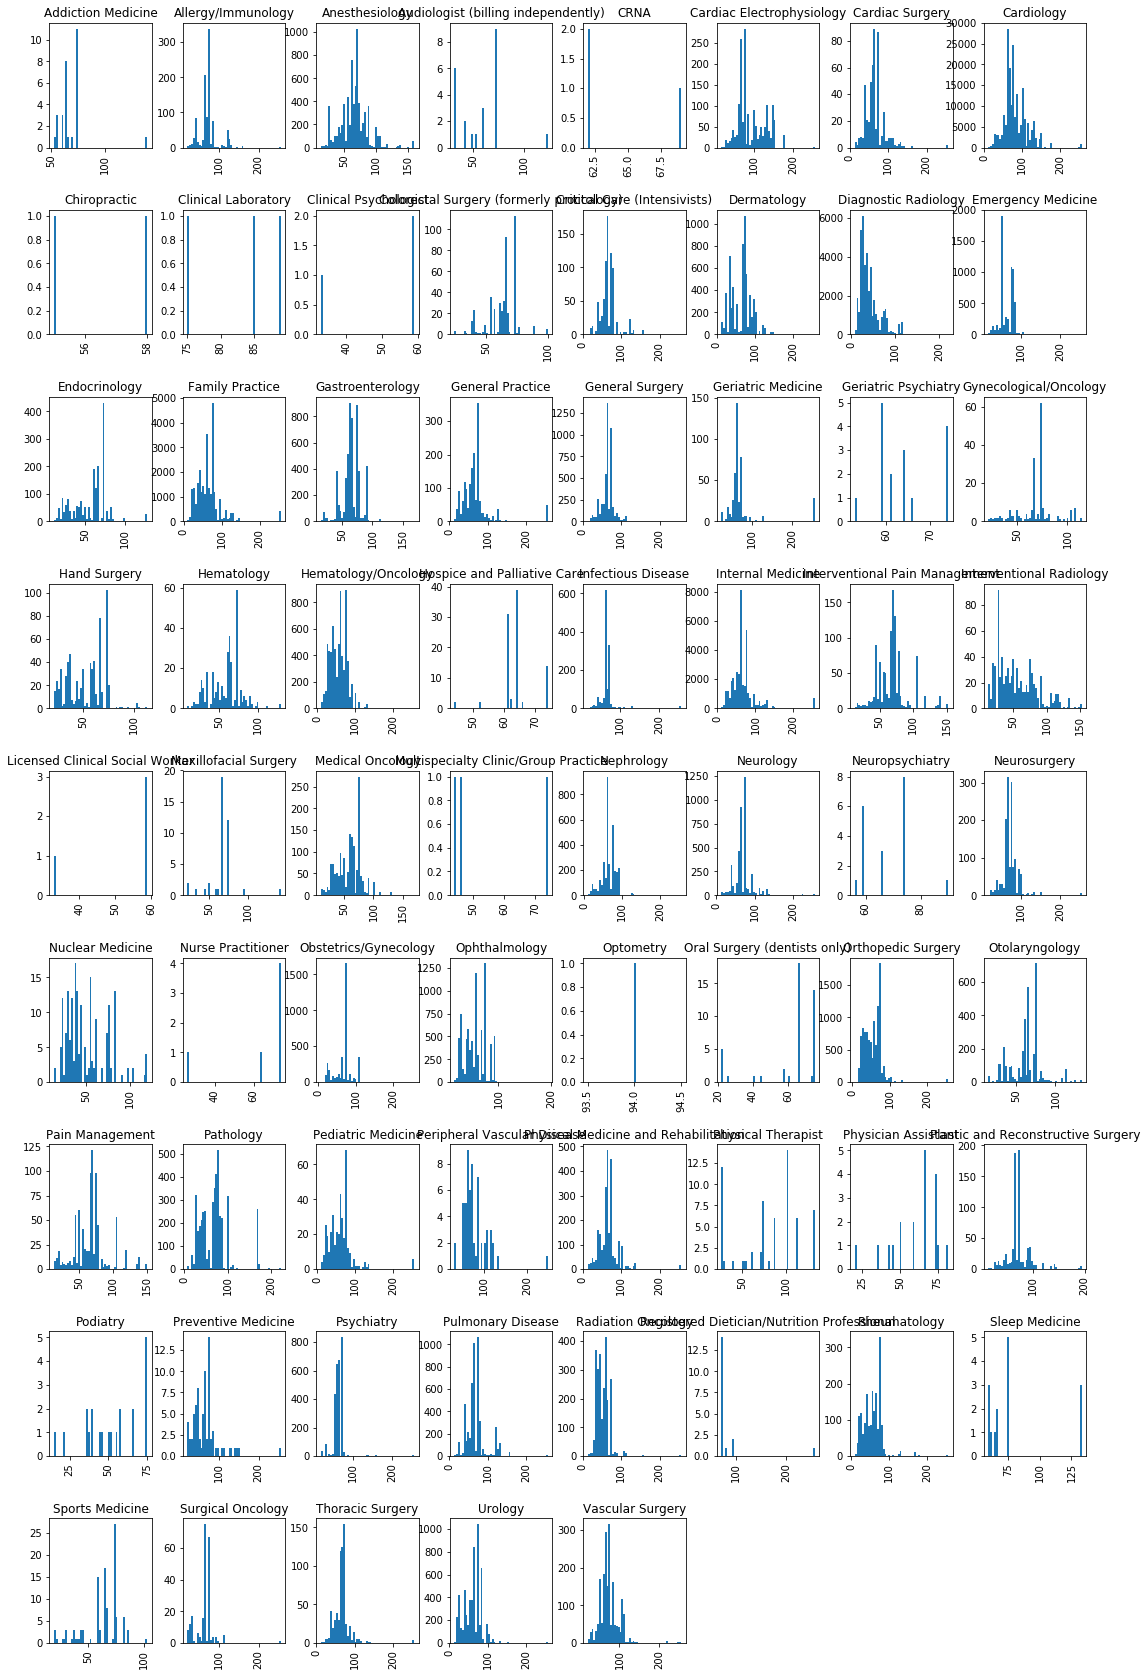

In [31]:
data.hist(column='length', by='specialty', bins=50, figsize=(18,30));

# Step 2: Data preprocessing

In [32]:
import re 

def clean_data(text_field):
    text_field = re.sub('[^a-zA-Z0-9]', ' ',text_field.lower())
    return text_field

In [33]:
print(data.procedure.head(1))

0    new_patient_office_or_other_outpatient_visit,_...
Name: procedure, dtype: object


In [34]:
corpus = data.procedure.apply(clean_data)
corpus.head()

0    new patient office or other outpatient visit  ...
1    new patient office or other outpatient visit  ...
2    new patient office or other outpatient visit  ...
3    established patient office or other outpatient...
4    established patient office or other outpatient...
Name: procedure, dtype: object

In [35]:
# split into train test
from sklearn.model_selection import train_test_split
y = data['is_cardiologist'].values
X_train, X_test, y_train, y_test = train_test_split(corpus, y,test_size=0.25, random_state=0)

In [36]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(305017,) (101673,) (305017,) (101673,)


In [37]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words= "english")
X_train_cv = cv.fit_transform(X_train).toarray()
X_test_cv = cv.transform(X_test).toarray()

In [38]:
print(X_train_cv.shape, X_test_cv.shape)

(305017, 2218) (101673, 2218)


In [39]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train_cv)
X_test_scaled = sc.transform(X_test_cv)

c:\users\ss\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [40]:
#  non scaled data with MulinomialNB 
#  need tfidf vectors for guassianNB 
#  occurence vector (0s & 1s)  with BernaulliNB

In [41]:

# Fitting Naive Bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train_cv, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [42]:
#predicting the test results
y_pred = model.predict(X_test_cv)
y_pred_proba = model.predict_proba(X_test_cv)

In [43]:
#Making the confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()


In [44]:
def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

In [45]:

print( np.array([ [tp, fn], [fp, tn] ] ) )

[[29764 18140]
 [ 3662 50107]]


In [46]:
(tp + tn )/ (tp+tn+fn+fp)

0.7855674564535324

In [47]:
# classification report
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred, normalize = True))

             precision    recall  f1-score   support

      False       0.73      0.93      0.82     53769
       True       0.89      0.62      0.73     47904

avg / total       0.81      0.79      0.78    101673

Accuracy Score: 0.7855674564535324


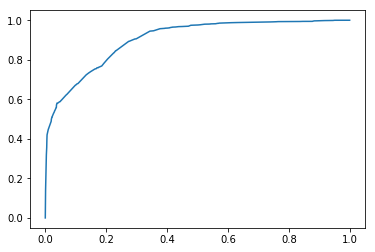

In [48]:
# ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, ths = roc_curve(y_test, y_pred_proba[:,1])
plt.plot(fpr,tpr)

In [49]:
from sklearn.metrics import auc
roc_auc = auc(fpr,tpr)
print("Area under the curve : ", roc_auc)

Area under the curve :  0.902798774185156


In [50]:
#importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
#matplotlib inline


# ------------ data pipeline -----------------

# =============================================================================
# def clean_data(text_field):
#     text_field = re.sub('[^a-zA-Z0-9]', ' ',text_field.lower())
#     return text_field
#
# #importing the dataset
# file_name="labelled.csv"
# data = pd.read_csv(file_name)
#
# data['is_cardiologist'] = data.specialty.str.contains("Card")
#
# data['corpus'] = data.procedure.apply(clean_data)
#
#
# data.to_csv("corpus.csv")
#
# =============================================================================

# importing the processed dataset
file_name="corpus.csv"
data = pd.read_csv(file_name)


# split into train test
from sklearn.model_selection import train_test_split
y = data['is_cardiologist'].values
X_train, X_test, y_train, y_test = train_test_split(data.corpus, y,test_size=0.25, random_state=0)


# Bag of words model
print ("TFIDF vectorizer..." )

from sklearn.feature_extraction.text import TfidfVectorizer 
cv = TfidfVectorizer(max_features = 100, stop_words= "english")
print(cv)

X_train_cv = cv.fit_transform(X_train).toarray()
X_test_cv = cv.transform(X_test).toarray()


# Feature Scaling
# =============================================================================
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train_scaled = sc.fit_transform(X_train_cv)
# X_test_scaled = sc.transform(X_test_cv)
# =============================================================================

# Fitting Naive Bayes import GaussianNB
print("MultinomialNB...")
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train_cv, y_train)

#predicting the test results
y_pred = model.predict(X_test_cv)
y_pred_proba = model.predict_proba(X_test_cv)

#Making the confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# classification report
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test, y_pred))
print("Accuracy Score Train:", accuracy_score(y_train, model.predict(X_train_cv), normalize = True))
print("Accuracy Score Test:", accuracy_score(y_test, y_pred, normalize = True))

# ROC curve
# =============================================================================
from sklearn.metrics import roc_curve
fpr, tpr, ths = roc_curve(y_test, y_pred_proba[:,1])
# plt.plot(fpr,tpr)
# plt.show()

from sklearn.metrics import auc
roc_auc = auc(fpr,tpr)
print("Area under the curve : ", roc_auc)

# save model
# save_model_filename = "model.joblib"
# print("Saving Model to", "model.joblib" )
# from sklearn.externals import joblib
# joblib.dump(model, save_model_filename)


TFIDF vectorizer...
TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)
MultinomialNB...
             precision    recall  f1-score   support

      False       0.68      0.85      0.76     53769
       True       0.77      0.55      0.64     47904

avg / total       0.72      0.71      0.70    101673

Accuracy Score Train: 0.709321119806437
Accuracy Score Test: 0.7084870122844806
Area under the curve :  0.7917032098069436


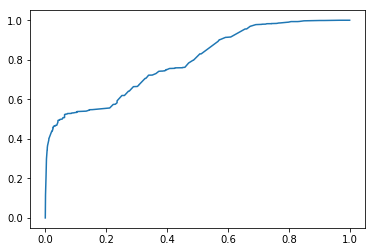

In [51]:
plt.plot(fpr,tpr)
plt.show()

In [52]:
y_pred[:10]

array([False, False, False, False,  True, False, False, False,  True,
        True])

In [53]:
y_pred_proba[:10]

array([[7.70451459e-01, 2.29548541e-01],
       [6.57688625e-01, 3.42311375e-01],
       [8.89076933e-01, 1.10923067e-01],
       [9.61472935e-01, 3.85270650e-02],
       [1.15015813e-03, 9.98849842e-01],
       [9.99771560e-01, 2.28439575e-04],
       [8.89076933e-01, 1.10923067e-01],
       [9.67833268e-01, 3.21667316e-02],
       [5.05128450e-03, 9.94948716e-01],
       [4.47161332e-03, 9.95528387e-01]])

In [54]:
cv1 = TfidfVectorizer(max_features = 100, stop_words= "english")
X1 = data.corpus.values
X1_vectorized = cv.fit_transform(X1).toarray()

In [55]:
y1_ped_proba = model.predict_proba(X1_vectorized)
y1_ped = model.predict(X1_vectorized)

In [56]:
pd.DataFrame(y1_ped_proba).describe()

,0,1
count,406690.000000,406690.000000
mean,0.542160,0.457840
std,0.335636,0.335636
min,0.000044,0.000036
25%,0.199357,0.207146
50%,0.614819,0.385181
75%,0.792854,0.800643
max,0.999964,0.999956


In [57]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'physician_id', 'procedure_code',
       'procedure', 'number_of_patients', 'id', 'specialty', 'is_cardiologist',
       'corpus'],
      dtype='object')

In [58]:
y1_ped_proba[:, 1].shape

(406690,)

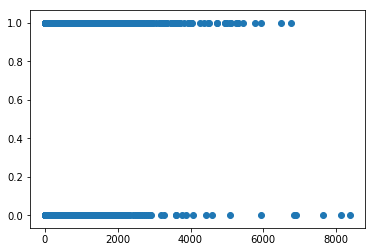

In [59]:
plt.scatter(  data.number_of_patients, data.is_cardiologist);

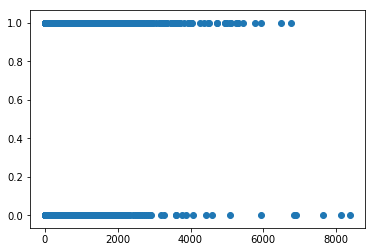

In [60]:
plt.scatter(  data.number_of_patients, data.is_cardiologist);

In [61]:
data.corpus.describe()

count                                                406690
unique                                                 2757
top       established patient office or other outpatient...
freq                                                  17869
Name: corpus, dtype: object

In [62]:
data['predicted']= 

SyntaxError: invalid syntax (<ipython-input-62-f54e6473acdb>, line 1)

In [ ]:
data.predicted_proba.describe()

In [ ]:
data[:100]